In [1]:
import pathlib, sys

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [2]:
import math
import numpy as np
from dataclasses import replace
import qutip
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
%reload_ext autoreload
%autoreload 2

import bec
from tools.jupyter import print_model_info
from tools.qutip import TqdmProgressBar

In [4]:
n_bosons = 8
phase = 0  # np.pi / 4
# model = BEC_Qubits.init_alexey2003(n_bosons=n_bosons, phase=phase)
model = bec.BEC_Qubits.init_default(
    n_bosons=n_bosons,
    phase=phase,
    excitation_level=True,
)
print_model_info(model)

BEC_Qubits(n_bosons=8, coupling_strength=1, transition_ampl=1, transition_freq=11, resonance_freq=1, phase=0, excitation_level=True, communication_line=False)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Активируем уровни возбудженного состояния и линии связи

In [5]:
ecmodel = replace(model, excitation_level=True, communication_line=True)

Начальное состояние системы: суперпозиция между атомами a и b

In [6]:
init_state = (
    bec.coherent_state_constructor(ecmodel, n=2, k=0)
    * bec.coherent_state_constructor(
        ecmodel, 2, 1, math.sqrt(1 / 10), math.sqrt(9 / 10)
    )
    * bec.vacuum_state(ecmodel, n=2)
)

## Эволюция под действием эффективного гамильтониана (6) из работы Rosseau2014

In [7]:
h_eff = bec.hamiltonian_eff(ecmodel, n=2)
h_eff_zz_and_zeeman = bec.hamiltonian_eff(ecmodel, n=2, quadratic=False)
h_eff_zz_only = bec.hamiltonian_eff(ecmodel, n=2, quadratic=False, zeeman=False)

h_eff == h_eff_zz_only or h_eff == h_eff_zz_and_zeeman or h_eff_zz_only == h_eff_zz_and_zeeman

/Users/kephircheek/Projects/RSF-Entanglement_Generation_between_BEC/research-emqwuqoc/libs/bec.py:86: UserWarning: Means \delta_l = \delta_c = \delta
  warnings.warn("Means \delta_l = \delta_c = \delta")


False

In [8]:
h_eff_zz_only_alexey = bec.hzz(ecmodel, n=2)

In [9]:
h_ad = bec.hamiltonian_ad(ecmodel, n=2)

In [10]:
h_int_approx = bec.h_int_approx(ecmodel, n=2)

In [11]:
tspan, dt = np.linspace(0, 3500, 351, retstep=True)

t_list = tspan

entropy_eff = [
    qutip.entropy_vn(qutip.ptrace(s, [0, 1]))
    for s in tqdm(
        qutip.mesolve(h_eff, init_state, t_list, progress_bar=TqdmProgressBar()).states
    )
]

entropy_eff_zz_and_zeeman = [
    qutip.entropy_vn(qutip.ptrace(s, [0, 1]))
    for s in tqdm(
        qutip.mesolve(
            h_eff_zz_and_zeeman, init_state, t_list, progress_bar=TqdmProgressBar()
        ).states
    )
]

entropy_eff_zz_only = [
    qutip.entropy_vn(qutip.ptrace(s, [0, 1]))
    for s in tqdm(
        qutip.mesolve(
            h_eff_zz_only, init_state, t_list, progress_bar=TqdmProgressBar()
        ).states
    )
]

entropy_eff_zz_only_alexey = [
    qutip.entropy_vn(qutip.ptrace(s, [0, 1]))
    for s in tqdm(
        qutip.mesolve(
            h_eff_zz_only_alexey, init_state, t_list, progress_bar=TqdmProgressBar()
        ).states
    )
]

entropy_ad = [
    qutip.entropy_vn(qutip.ptrace(s, [0, 1]))
    for s in tqdm(
        qutip.mesolve(h_ad, init_state, t_list, progress_bar=TqdmProgressBar()).states
    )
]

entropy_int_approx = [
    qutip.entropy_vn(qutip.ptrace(s, [0, 1]))
    for s in tqdm(
        qutip.mesolve(
            h_int_approx, init_state, t_list, progress_bar=TqdmProgressBar()
        ).states
    )
]

/Users/kephircheek/venvs/science/emqwuqoc-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 351/351 [00:09<00:00, 37.54it/s]


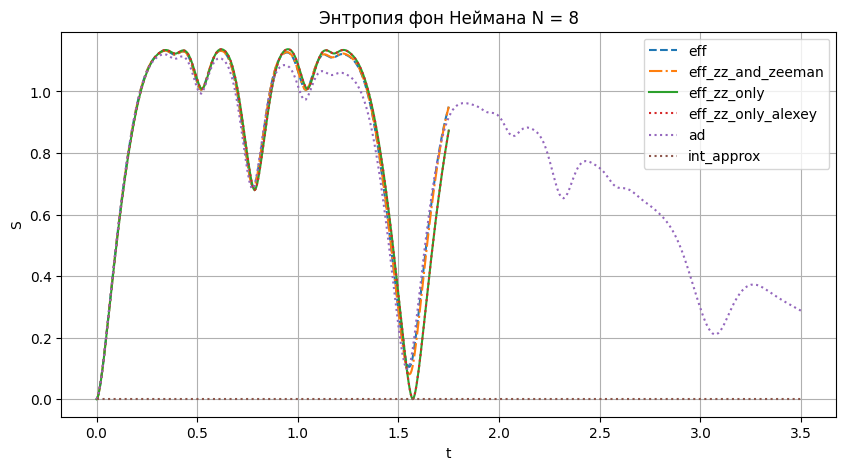

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan * model.Omega, entropy_eff, "--", label="eff")
ax.plot(tspan * model.Omega, entropy_eff_zz_and_zeeman, "-.", label="eff_zz_and_zeeman")
ax.plot(tspan * model.Omega, entropy_eff_zz_only, "-", label="eff_zz_only")
ax.plot(
    tspan * model.Omega, entropy_eff_zz_only_alexey, ":", label="eff_zz_only_alexey"
)
ax.plot(tspan * model.Omega * 2, entropy_ad, ":", label="ad")
ax.plot(tspan * model.Omega * 2, entropy_int_approx, ":", label="int_approx")


ax.set_ylabel("S")
ax.set_xlabel("t")
ax.set_title(f"Энтропия фон Неймана N = {ecmodel.n_bosons}")
ax.grid()
ax.legend()

# plt.savefig("/Users/kephircheek/Downloads/vn-entropy-N8.png")